# Deep Hedging AI
### Example network showing caching

Hans Buehler, January 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

Deep Hedging AI says hello ... Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


## Create

Gym with 2414 trainable weights compiled and initialized. Took 17s
Agent is using 2412 weights: 2401 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/d5c51786b2d3c5cbdcde3e430c22c5e620658b894c8

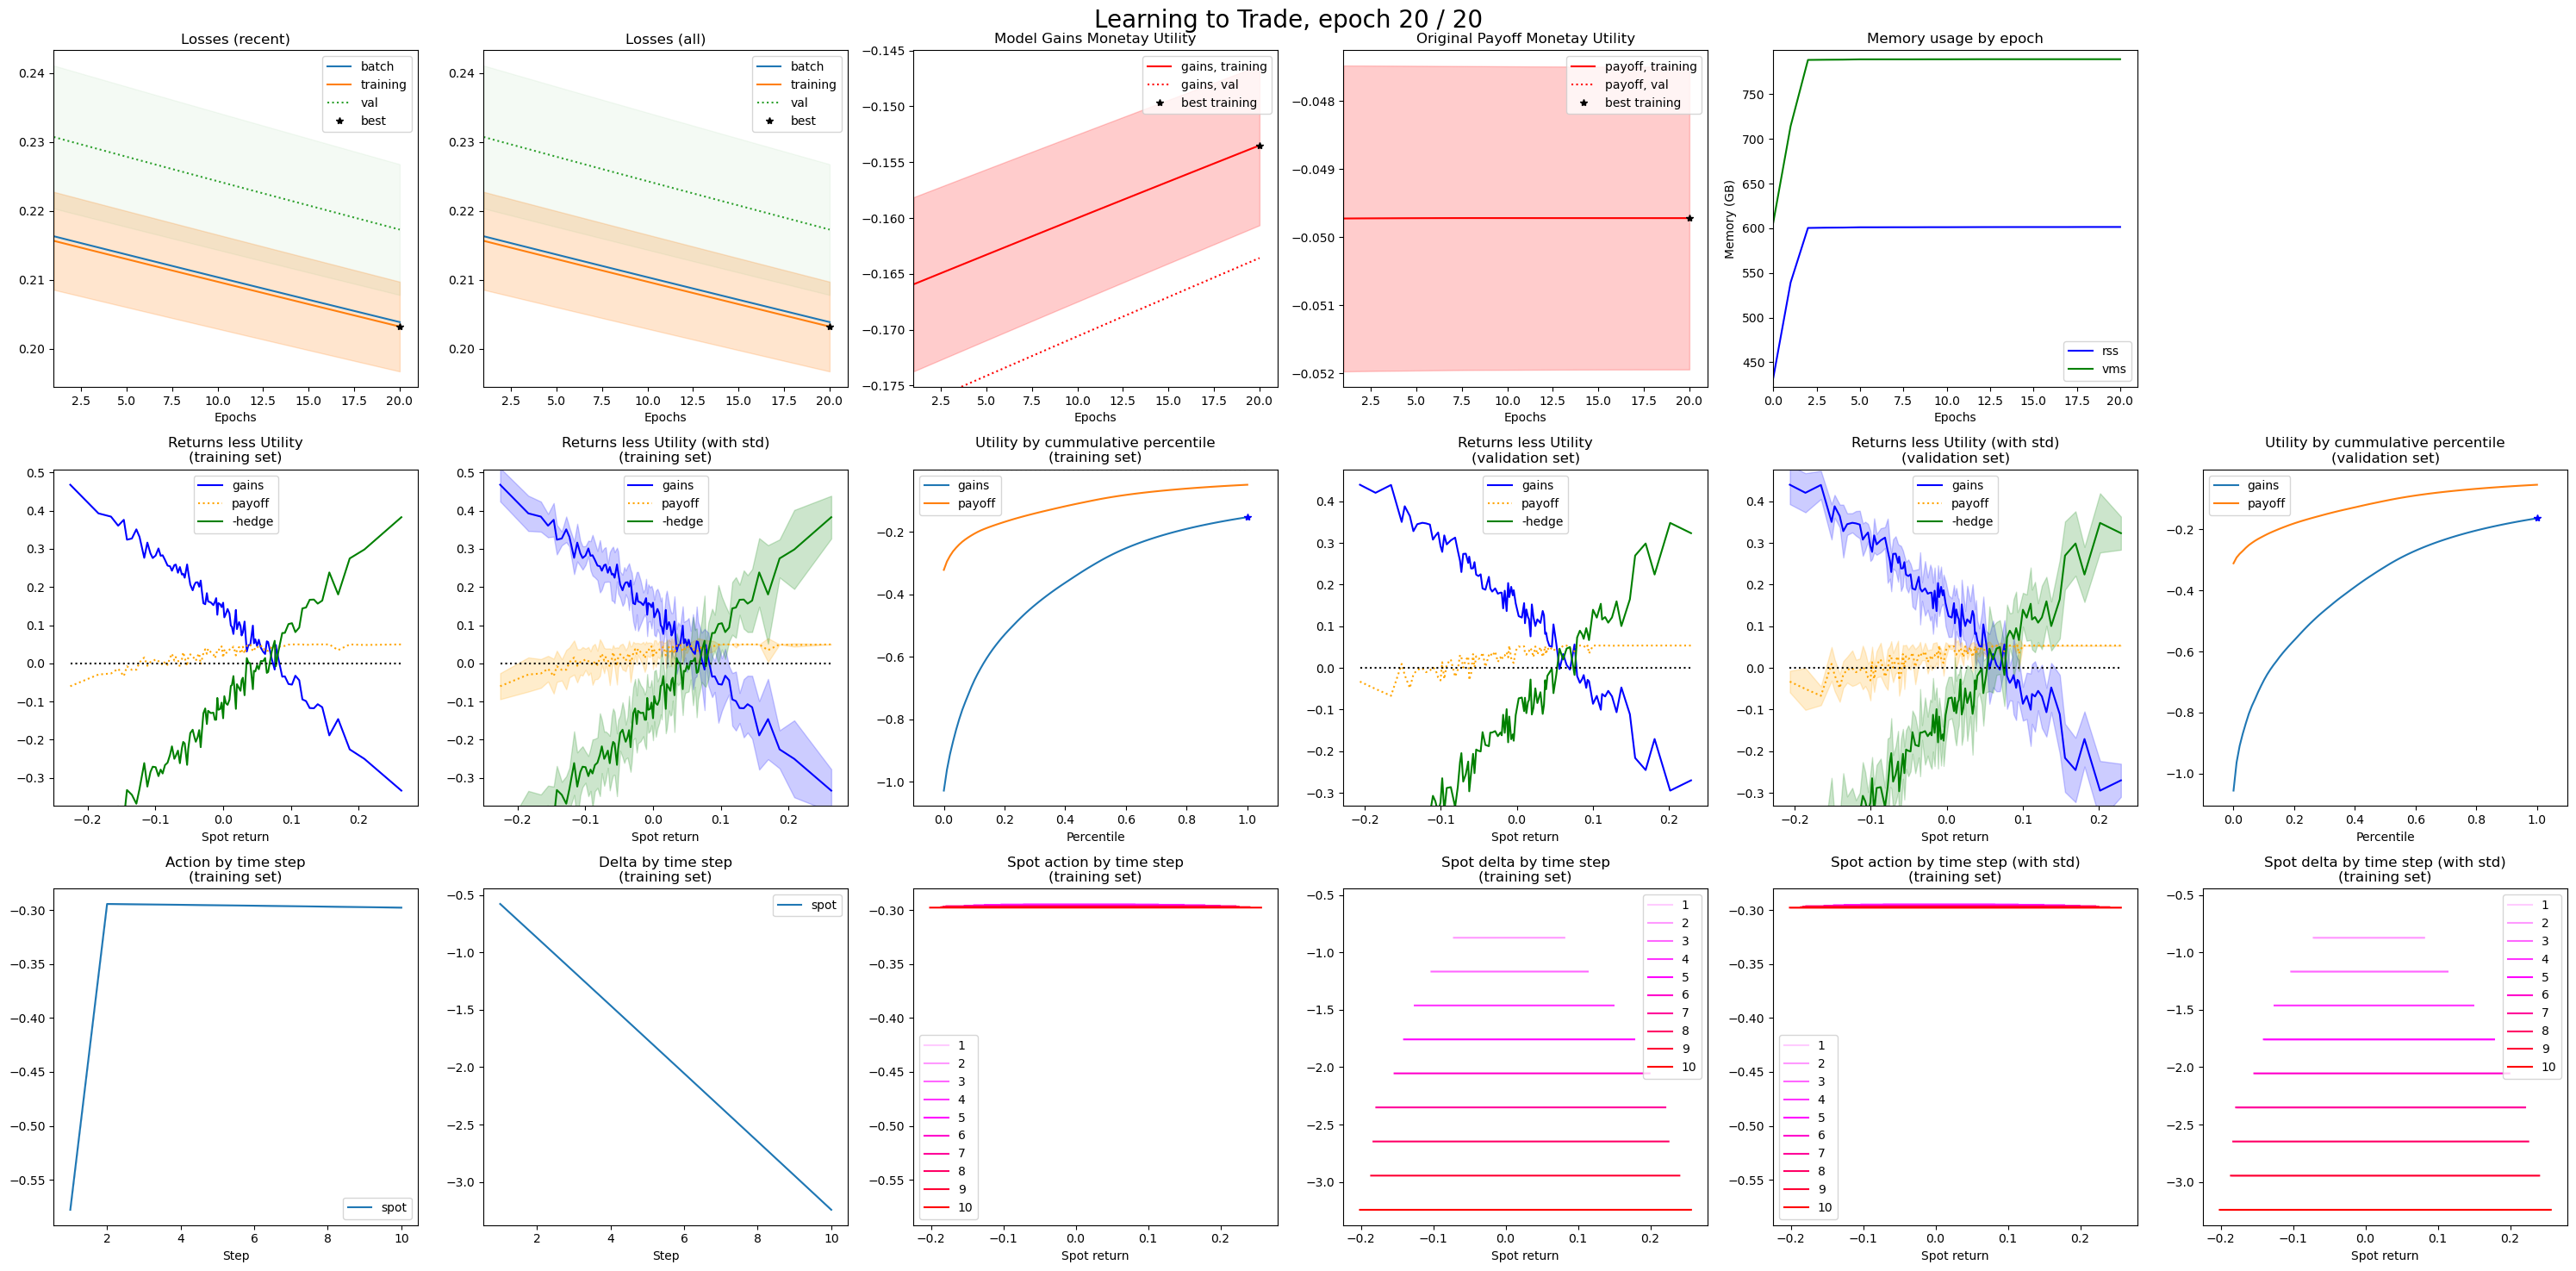

Training 20/20 epochs; 2414 weights; 1000 samples; 500 validation samples batch size 1000 | initial loss 0.216329 (0.00713823), training 0.203219 (0.00651368), best 0.203219 (0.00713823), batch 0.203866, val 0.217297 (0.00948923). Best epoch 20; last cached 20. | memory used: rss 601.457M, vms 789.266M | time elapsed 35s; time per epoch 1s; estimated time remaining 0s                        
 Status: Training complete.
 Weights set to best epoch: 20
 State of training until epoch 20 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/d5c51786b2d3c5cbdcde3e430c22c5e620658b894c8c1321.pck

Training terminated. Total time taken 1:53


## Restore

Gym with 2414 trainable weights compiled and initialized. Took 1s
Agent is using 2412 weights: 2401 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ 'C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/d5c51786b2d3c5cbdcde3e430c22c5e620658b894c8c

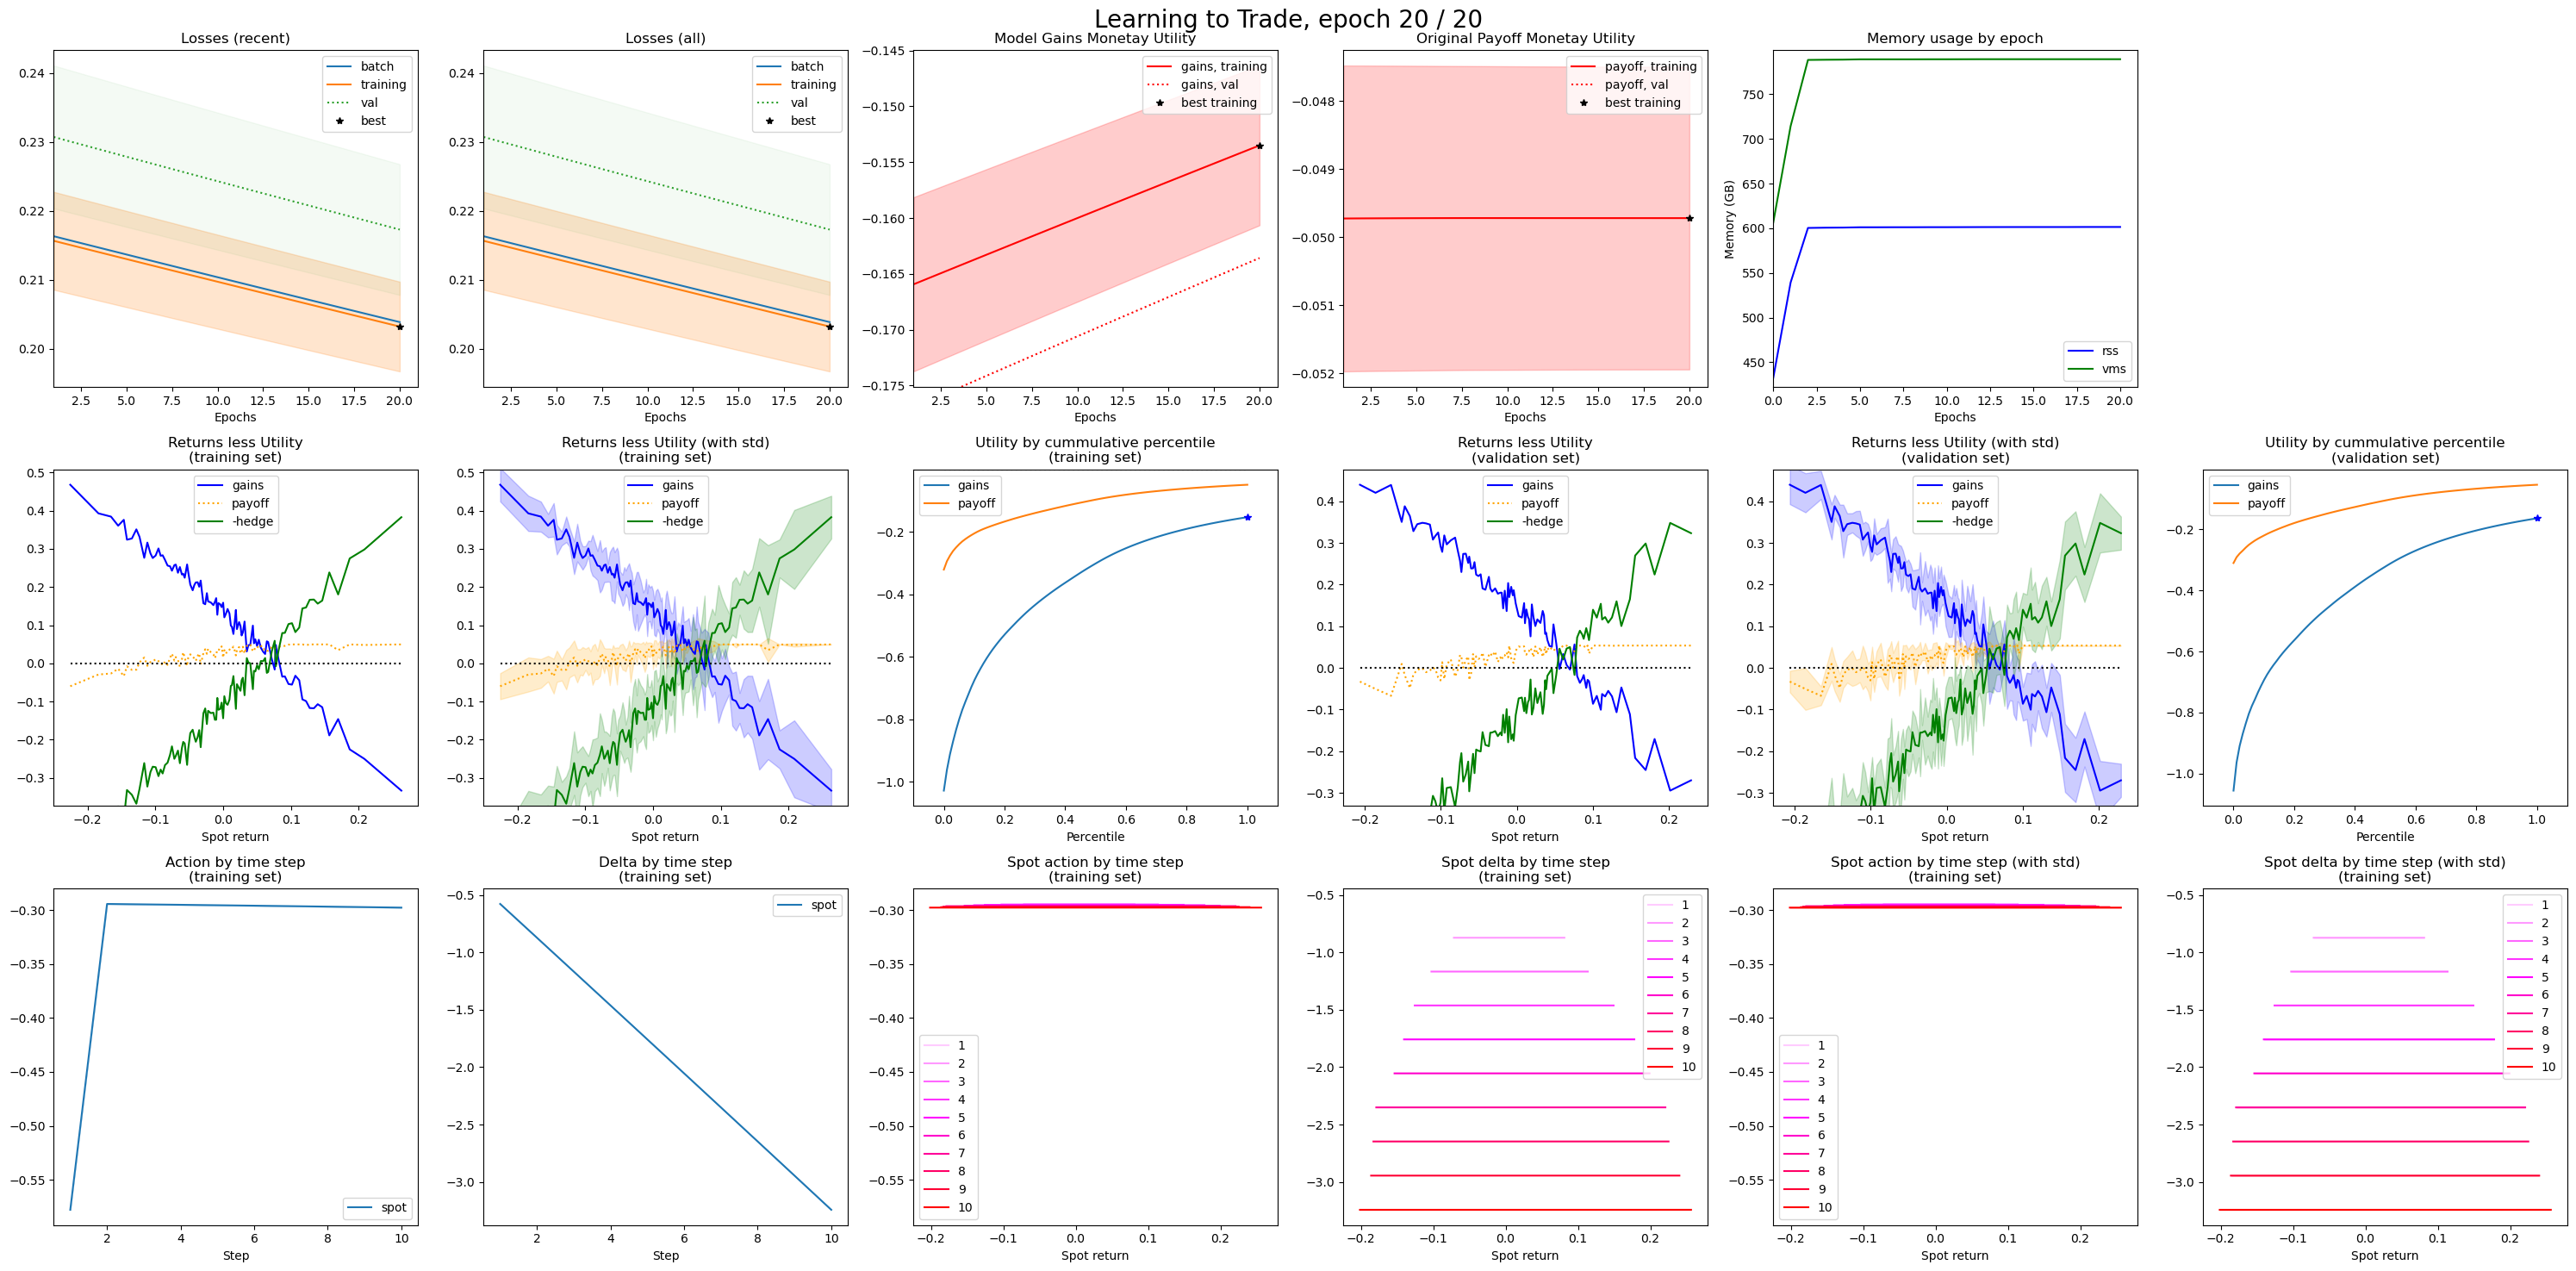

Training 20/20 epochs; 2414 weights; 1000 samples; 500 validation samples batch size 1000 | initial loss 0.216329 (0.00713823), training 0.203219 (0.00651368), best 0.203219 (0.00713823), batch 0.203866, val 0.217297 (0.00948923). Best epoch 20; last cached 20. | memory used: rss 601.457M, vms 789.266M | time elapsed 35s; time per epoch 1s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 20
 State of training until epoch 20 cached into C:/Users/hansb/iCloudDrive/Python3/deephedging/notebooks/.deephedging_cache/d5c51786b2d3c5cbdcde3e430c22c5e620658b894c8c1321.pck

Training terminated. Total time taken 14s


In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from cdxbasics.dynaplot import figure
from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world

def fwd_start( spots ):
    l          = spots.shape[1]
    terminal   = np.maximum( 1. * spots[:,l//2] - spots[:,-1], 0. )  # put
    return -terminal

config.world.samples = 1000
config.world.steps = 10
config.world.drift = 0.
config.world.black_scholes = True
config.world.payoff = fwd_start
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 5
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence   = 5 # continuous recurrent nodes
config.gym.agent.recurrence01 = 5 # digital recurrent nodes
config.gym.agent.recurrence_gru = True # digital recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.0001
config.trainer.train.optimizer.clipvalue = 0.9
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = config.world("samples")
config.trainer.train.epochs = 20
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_copy = config.copy()

# Create
# ======
config.trainer.caching.mode = "update"
display(Markdown("## Create"))

world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)
gym = VanillaDeepHedgingGym( config.gym )
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()

# Restore
# =======
config.trainer.caching.mode = "on"
display(Markdown("## Restore"))
config = config_copy
config.world.mark_done()
gym = VanillaDeepHedgingGym( config.gym )
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()